In [1]:
import sys
sys.path.append("/Isolation-Forest-For-Fraud-Detection/src/")
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from src.preprocessing.data import read_all_trx, train_test_split_transactions
from src.preprocessing.features import create_feature_matrix
from src.model.performance import evaluate_model, random_search_cv,time_window_cv
from src.model.anomalydetection import MahalanobisOneclassClassifier
from src.preprocessing.helpers import scenario_sample


#______________________________ DATA______________________________________
start = '2018-04-01'
end = '2018-09-30'
calendar = pd.date_range(start, end, inclusive="both").strftime('%Y-%m-%d')
root = "https://github.com/Fraud-Detection-Handbook/simulated-data-raw/blob/main/data/"
path_data = [f"{root}{date}.pkl?raw=true" for date in calendar]
transactions_df = read_all_trx(path_data).sort_values('TX_DATETIME').reset_index(drop=True)
scenario_1 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 1]
scenario_2 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 2]
scenario_3 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 3]
#_________________________________________________________________________


Execution time: 181.504953622818 seconds


In [2]:
#__________________________ FEATURES _________________________________
X = create_feature_matrix(transactions_df,windows_size_in_days = [1,5,7,15],delay_period=7)
target = "TX_FRAUD"

index = "TX_DATETIME"

train_period = "2018-07-01"

customer_features = [i for i in X.columns if "CUSTOMER_ID_" in i]

flag_features = [i for i in X.columns if "TX_FLAG_" in i]

terminal_features = [i for i in X.columns if "TERMINAL_ID_" in i]

time_features = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_MONTH', 'TX_DAY', 'TX_HOUR', 'TX_MINUTE', 'TX_DURING_WEEKEND',
                 'TX_DURING_NIGHT']

helper_columns = ['TX_FRAUD', 'TX_FRAUD_SCENARIO', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID']

features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features
#___________________________________________________________________

Execution time: 165.7923069000244 seconds
Execution time: 89.26153302192688 seconds
Execution time: 6.4449169635772705 seconds
Execution time: 266.19627928733826 seconds


In [3]:
#______________________________ TIME WINDOW SPLIT____________________________
model = IsolationForest()
results_ts = time_window_cv(transactions_df,model,features)
#____________________________________________________________________________


Creating features...
Execution time: 195.71347403526306 seconds
Execution time: 103.68688368797302 seconds
Execution time: 6.253700017929077 seconds
Execution time: 310.422265291214 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


In [5]:
results_ts.columns

Index(['train_start', 'train_end', 'test_start', 'test_end', 'execution_time',
       'model', 'validation'],
      dtype='object')

In [297]:
results_ts["validation"][0].round(2)

model     0.86
dummy     0.50
random    0.50
dtype: float64

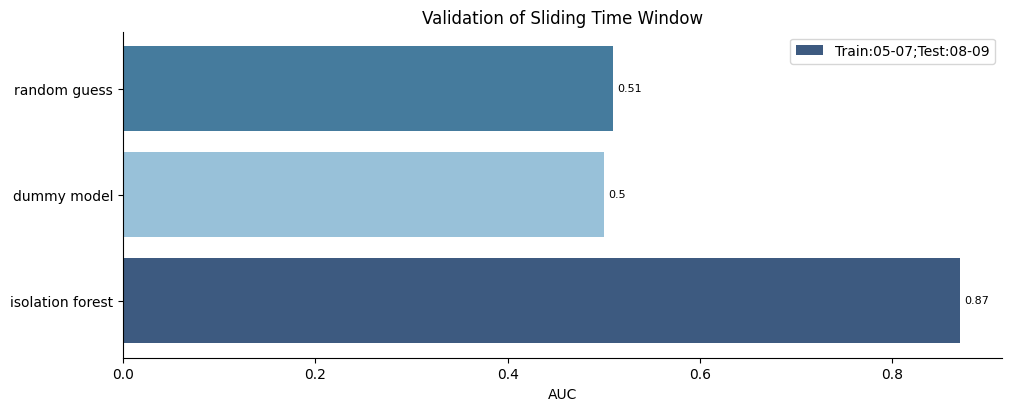

In [302]:
import matplotlib.pyplot as plt
import seaborn as sns
s = results_ts["validation"][1].round(2)
s.index = ['isolation forest','dummy model','random guess']

time_props = "Validation of Sliding Time Window"
legend_props = "Train:05-07;Test:08-09"
my_cmap = sns.light_palette("Blue", as_cmap=True)
fig, ax = plt.subplots(layout='constrained',figsize=(10, 4))
ax.set_title(f"{time_props}")
ax.set_xlabel("AUC")
colorad = ["#457b9d", "#98c1d9", "#3d5a80"]
ax.barh(y = s.index,width = s.values, color=colorad[::-1])
ax.bar_label(ax.containers[0],fontsize=8, padding=3)
ax.spines[['right', 'top']].set_visible(False)
ax.legend([legend_props])

fig.savefig('auc_sliding_time_window_2.png',transparent=True)

In [115]:
condition = transactions_df["TX_DATETIME"].between(results_ts.loc[0,"test_start"],
                                                   results_ts.loc[0,"test_end"])
transactions_df.loc[condition,"TX_FRAUD_SCENARIO"].value_counts()

0    294309
2      1588
3       861
1       171
Name: TX_FRAUD_SCENARIO, dtype: int64

In [116]:
condition = transactions_df["TX_DATETIME"].between(results_ts.loc[1,"test_start"],
                                                   results_ts.loc[1,"test_end"])
transactions_df.loc[condition,"TX_FRAUD_SCENARIO"].value_counts()

0    293889
2      1692
3       808
1       169
Name: TX_FRAUD_SCENARIO, dtype: int64

In [117]:
model = IsolationForest()
#________________________ FEATURE INDEPENDENT SPLIT _________________________
basic = ['TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']
features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features
auc_are_feat_type  = pd.DataFrame()
for feats in [basic,customer_features,time_features,terminal_features]:
    # Reports Performance
    auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)

indexlist = []
for feat in ["raw_features", "customer_features", "time_features", "terminal_features"]:
    for time in range(1, 3):
        indexname = feat + f"_time_folder_{time}"
        indexlist.append(indexname)
auc_are_feat_type.index = indexlist

validation_values  = auc_are_feat_type["validation"].explode()[0::3]
validation_values.name = "AUC"
validation_values.index = indexlist
auc_are_feat_type = pd.concat([auc_are_feat_type,validation_values],1)

Creating features...
Execution time: 201.62411999702454 seconds
Execution time: 106.66383004188538 seconds
Execution time: 8.038259744644165 seconds
Execution time: 321.19652462005615 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_21088\396918374.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)


Creating features...
Execution time: 191.8323347568512 seconds
Execution time: 102.13672852516174 seconds
Execution time: 7.892136812210083 seconds
Execution time: 306.4674961566925 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_21088\396918374.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)


Creating features...
Execution time: 190.36574697494507 seconds
Execution time: 100.8229033946991 seconds
Execution time: 8.001575946807861 seconds
Execution time: 303.7721381187439 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_21088\396918374.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)


Creating features...
Execution time: 190.4981973171234 seconds
Execution time: 102.01113033294678 seconds
Execution time: 7.730220079421997 seconds
Execution time: 304.83370423316956 seconds
Start Time Cross Validation...
Train: 2018-04-01 00:00:31 2018-06-01 00:00:31
Test: 2018-07-01 00:00:31 2018-08-01 00:00:31
Train: 2018-05-01 00:00:31 2018-07-01 00:00:31
Test: 2018-08-01 00:00:31 2018-09-01 00:00:31


C:\Users\david\AppData\Local\Temp\ipykernel_21088\396918374.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)
C:\Users\david\AppData\Local\Temp\ipykernel_21088\396918374.py:19: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  auc_are_feat_type = pd.concat([auc_are_feat_type,validation_values],1)


In [119]:
auc_are_feat_type["AUC"]

raw_features_time_folder_1         0.636272
raw_features_time_folder_2         0.635116
customer_features_time_folder_1    0.679754
customer_features_time_folder_2    0.678947
time_features_time_folder_1        0.503212
time_features_time_folder_2        0.502446
terminal_features_time_folder_1    0.721961
terminal_features_time_folder_2    0.721305
Name: AUC, dtype: object

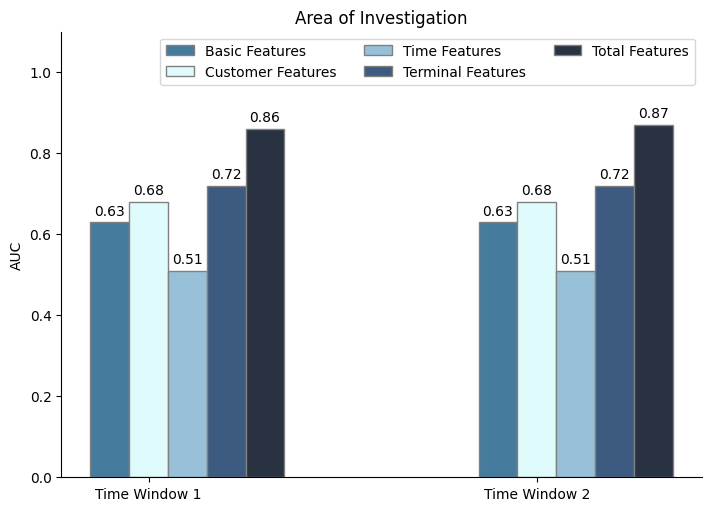

In [281]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

colorad = ["#457b9d","#e0fbfc", "#98c1d9", "#3d5a80","#293241"]
keycol = ['Basic Features','Customer Features','Time Features','Terminal Features','Total Features']
color_p = {k:v for k,v in zip(keycol,colorad)}
time = ("Time Window 1", "Time Window 2")
auc_means = {
    'Basic Features': (0.63, 0.63),
    'Customer Features': (0.68, 0.68),
    'Time Features': (0.51, 0.51),
    'Terminal Features': (0.72, 0.72),
    'Total Features': (0.86, 0.87)
}

x = np.arange(len(species))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained',figsize=(7,5))

for attribute, measurement in auc_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=color_p[attribute],edgecolor='grey')
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('Area of Investigation')
ax.set_xticks(x + width, species)
ax.legend(loc='best', ncols=3)
ax.set_ylim(0, 1.1)
ax.spines[['right', 'top']].set_visible(False)
plt.show()
fig.savefig('auc_features.png',transparent=True)

In [351]:
from sklearn.metrics import roc_auc_score

In [398]:
model = IsolationForest()
#________________________ SCENARIO  SPLIT ___________________________________
scenario_sensitivity = []
data_scenarios = []
for scenario in transactions_df["TX_FRAUD_SCENARIO"].unique()[1:]:
    scenario_x = scenario_sample(transactions_df,scenario)
    X_train,X_test,y_train,y_test = train_test_split_transactions(create_feature_matrix(scenario_x,
                                                                                        windows_size_in_days=[1, 5, 7, 15,30],
                                                                                        delay_period=7),
                                                                  features,
                                                                  train_start="2018-04-01", train_end="2018-07-01",
                                                                  test_start="2018-08-01",  test_end="2018-09-01",
                                                                  target="TX_FRAUD")
    
    
    # Fitting the model
    model.fit(X_train[features])
    # Reports Performance
    benchmark = evaluate_model(model, X_test, y_test)
    scenario_sensitivity.append(benchmark)
    data_scenarios.append([X_train,X_test,y_train,y_test,model])

    
scenario_sensitivity = pd.concat(scenario_sensitivity,axis=1).T
scenario_sensitivity.index = [f"scenario_{i}" for i in range(1,4)]
data_scenarios_dict = {k:v for k,v in zip([f"scenario_{i}" for i in range(1,4)],data_scenarios) } 
scenario_sensitivity
#____________________________________________________________________________

Execution time: 200.33587050437927 seconds
Execution time: 113.55439925193787 seconds
Execution time: 8.277944087982178 seconds
Execution time: 326.99898171424866 seconds
Execution time: 199.7656512260437 seconds
Execution time: 104.6150860786438 seconds
Execution time: 8.72503113746643 seconds
Execution time: 317.9078688621521 seconds
Execution time: 199.69451928138733 seconds
Execution time: 108.36379885673523 seconds
Execution time: 9.441814184188843 seconds
Execution time: 322.5155556201935 seconds


,model,dummy,random
scenario_1,0.998199,0.5,0.506666
scenario_2,0.962849,0.5,0.498437
scenario_3,0.724666,0.5,0.511679


In [326]:
scenario_sensitivity.loc["scenario_1"]

model     0.997854
dummy     0.500000
random    0.511790
Name: scenario_1, dtype: float64

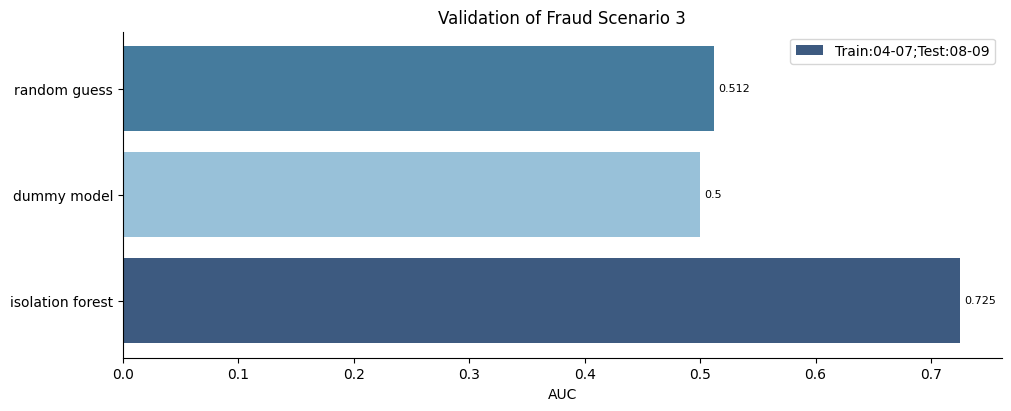

In [406]:
import matplotlib.pyplot as plt
import seaborn as sns
n =3
s = scenario_sensitivity.loc[f"scenario_{n}"].round(3)
s.index = ['isolation forest','dummy model','random guess']

time_props = f"Validation of Fraud Scenario {n}"
legend_props = "Train:04-07;Test:08-09"
my_cmap = sns.light_palette("Blue", as_cmap=True)
fig, ax = plt.subplots(layout='constrained',figsize=(10, 4))
ax.set_title(f"{time_props}")
ax.set_xlabel("AUC")
colorad = ["#457b9d", "#98c1d9", "#3d5a80"]
ax.barh(y = s.index,width = s.values, color=colorad[::-1])
ax.bar_label(ax.containers[0],fontsize=8, padding=3)
ax.spines[['right', 'top']].set_visible(False)
ax.legend([legend_props])

fig.savefig(f'auc_fraud_scenario_{n}.png',transparent=True)

In [337]:
def evaluate_model(model, X_test, y_test, benchmark=True):
    """
        Evaluates the performance of the model using AUC

        Parameters:
        model (object): The trained model that will be used to make predictions
        X_test (pd.DataFrame): The test set
        y_test (pd.Series): The true labels of the test set

        Returns:
        pd.DataFrame: A dataframe containing  benchmark
    """
    # Make predictions using model,random and dummy
    # Note that model score are flipped for scikit learn evaluation greater better
    scores = -model.score_samples(X_test)
    if benchmark:
        random_scores = np.random.uniform(size=len(y_test))
        dummy_not = np.zeros_like(y_test)
        # Summarize in benchmark
        benchmark = {
            "model":  roc_auc_score(y_test, scores),
            "dummy":  roc_auc_score(y_test, dummy_not),
            "random": roc_auc_score(y_test, random_scores)
        }
        result = pd.Series(benchmark)
    else:
        result = roc_auc_score(y_test, scores)
    return result


In [ ]:
from sklearn.metrics import plot_roc_curve

1
2
3


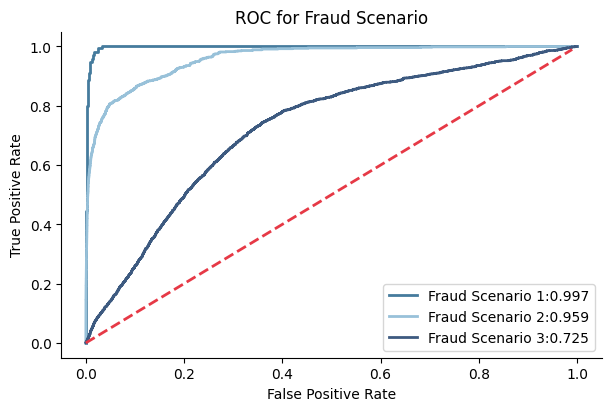

In [402]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


fig, ax = plt.subplots(layout='constrained',figsize=(6, 4))
for n,c in enumerate(["#457b9d", "#98c1d9", "#3d5a80"]):
    n+=1
    X_test =  data_scenarios_dict[f"scenario_{n}"][1]
    y_test =  data_scenarios_dict[f"scenario_{n}"][3]
    scores = -data_scenarios_dict[f"scenario_{n}"][-1].score_samples(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,scores,pos_label=1)
    auc = roc_auc_score(y_test, scores)
    ax.plot(fpr, tpr, color =  c,linestyle = "-" ,lw=2,label = f"Fraud Scenario {n}:{round(auc,3)}")
    
ax.plot(np.arange(100)/100, np.arange(100)/100, '#e63946',linestyle = "--", lw=2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f"ROC for Fraud Scenario")
ax.spines[['right', 'top']].set_visible(False)
ax.legend()
plt.show()
fig.savefig(f'roc_fraud_scenarios.png',transparent=True)